<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Quantum Volume
---

* **Last Updated:** March 1, 2019
* **Requires:** qiskit-terra 0.7, qiskit-ignis 0.1, qiskit-aer 0.1


## Introduction

**Quantum Volume (QV)** is a method to verify device performance and a metric to quantify the computational power of a quantum device.  The method is based on the paper "Validating quantum computers using randomized model circuits" (https://arxiv.org/abs/1811.12926). 

This notebook gives an example for how to use the ``ignis.verification.quantum_volume`` module. This particular example shows how to run 4-qubit quantum volume circuits and will run them using the noisy Aer simulator.

In [86]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the qv function.
import qiskit.ignis.verification.quantum_volume as qv

## Select the Parameters of the QV Run

In this example we have 4 qubits Q0,Q1,Q3,Q5. 
We are running up to depth 6

In [87]:
#Qubit list
qubit_list = [0,1,2,4,7]
depth_list = np.arange(7)+1
ntrials = 10

## Generate QV sequences

We generate the quantum volume sequences. We start with a small example (so it doesn't take too long to run).


In [88]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
%autoreload 2
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_list, depth_list, ntrials)

In [90]:
#pass the circuits through the compiler so that the random SU(4) unitaries are converted to CNOTS
for trial in range(ntrials):
    qv_circs[trial] = qiskit.transpiler.transpile(qv_circs[trial])

In [91]:
#pass the circuits through the compiler so that the random SU(4) unitaries are converted to CNOTS
for trial in range(ntrials):
    qv_circs_nomeas[trial] = qiskit.transpiler.transpile(qv_circs_nomeas[trial])

As an example, we print the circuit corresponding to the first QV sequence

In [92]:
print(qv_circs_nomeas[0][0])

         ┌────────────────────────────┐          ┌──────────────────┐     ┌───┐»
qr_0: |0>┤ U3(0.93099,-2.8441,2.6233) ├───────■──┤ U3(-0.82884,0,0) ├─────┤ X ├»
         ├────────────────────────────┤       │  ├──────────────────┤┌───┐└─┬─┘»
qr_1: |0>┤ U3(2.1169,-1.3183,1.4899)  ├──■────┼──┤ U3(-1.6525,0,0)  ├┤ X ├──┼──»
         ├────────────────────────────┤┌─┴─┐  │  ├──────────────────┤└─┬─┘  │  »
qr_2: |0>┤ U3(2.6229,-1.0939,1.7052)  ├┤ X ├──┼──┤ U3(0,0,-0.11002) ├──■────┼──»
         ├────────────────────────────┤└───┘┌─┴─┐├──────────────────┤       │  »
qr_3: |0>┤  U3(1.5308,1.196,-2.8676)  ├─────┤ X ├┤  U3(0,0,1.2703)  ├───────■──»
         └────────────────────────────┘     └───┘└──────────────────┘          »
qr_4: |0>──────────────────────────────────────────────────────────────────────»
                                                                               »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                            

## Simulate the ideal circuits

The quantum volume method requires that we know the ideal output for each circuit, so use the statevector simulator in Aer to get the ideal result.

In [93]:
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('statevector_simulator')
ideal_results = []
for trial in range(ntrials):
    print('Simulating trial %d'%trial)
    ideal_results.append(qiskit.execute(qv_circs_nomeas[trial], backend=backend).result())


Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4
Simulating trial 5
Simulating trial 6
Simulating trial 7
Simulating trial 8
Simulating trial 9


Next, load the ideal results into a quantum volume fitter

In [153]:
%autoreload 2
qv_fitter = qv.QVFitter(qubit_list=qubit_list, depth_list=depth_list)
qv_fitter.add_statevectors(ideal_results)

## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [154]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
#noise_model = None

## Execute on Aer simulator

We can execute the RB sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, 
and obtain a list of results **result_list**.

In [155]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 5024
exp_results = []
for trial in range(ntrials):
    print('Running trial %d'%trial)
    exp_results.append(qiskit.execute(qv_circs[trial], basis_gates=basis_gates, backend=backend, noise_model=noise_model, backend_options={'max_parallel_experiments': 0}).result())

Running trial 0
Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9


Load the experimental data into the fitter. The data will keep accumulating if this is re-run (unless the fitter is re-instantiated).

In [158]:
qv_fitter.add_data(exp_results)

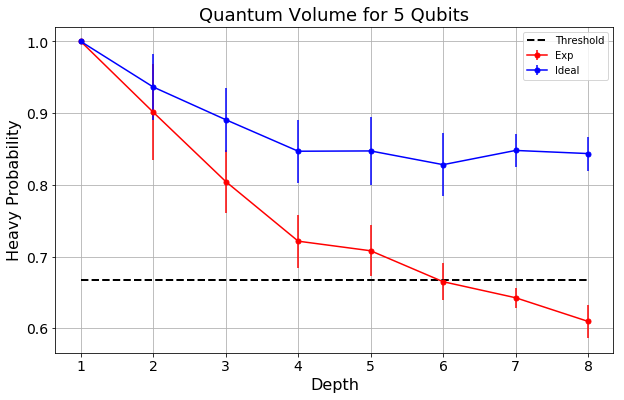

In [159]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for %d Qubits'%(len(qubit_list)), fontsize=18)

plt.show()